In [10]:
# importing the necessary libraries

from scipy.sparse import vstack, csr_matrix, csc_matrix
from scipy.sparse.data import _data_matrix
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.datasets import make_classification

Dataset Source: This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases

In [2]:
# read the csv file
df = pd.read_csv("C:/Users/prath/Downloads/MCA/diabetes.csv")

# displays the first 5 rows of the dataframe
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# Graph

Outcome based on Age Group

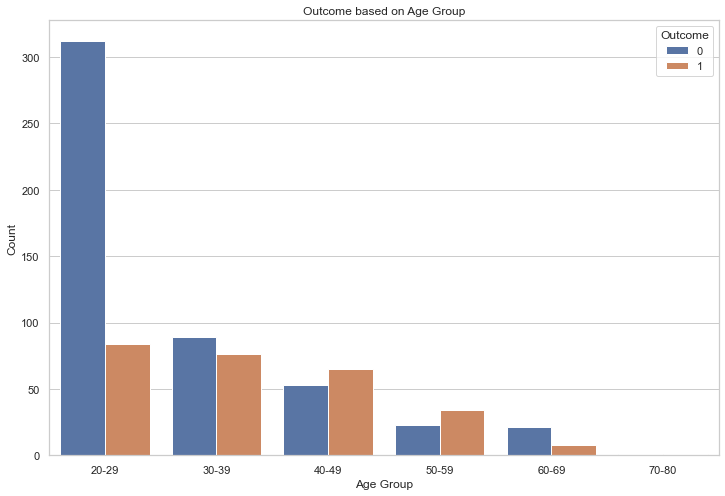

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Define age groups
bins = [20, 30, 40, 50, 60, 70, 80]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-80']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Bar plot for Outcome based on Age Group
plt.figure(figsize=(12, 8))
sns.countplot(x='AgeGroup', hue='Outcome', data=df)
plt.title('Outcome based on Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

Distribution of Outcome

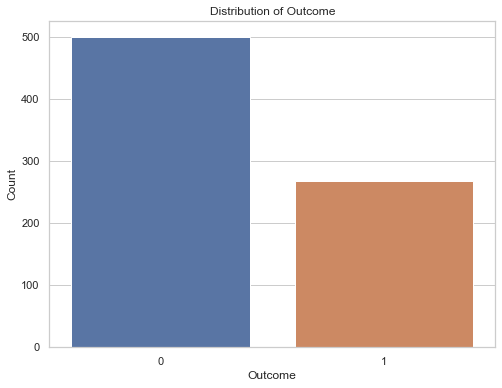

In [17]:
import seaborn as sns

# Bar plot for Outcome
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Outcome')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

Distribution of BMI

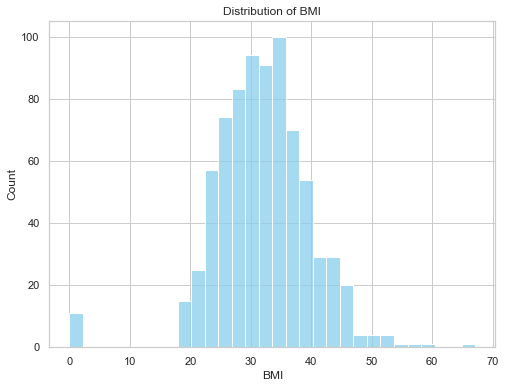

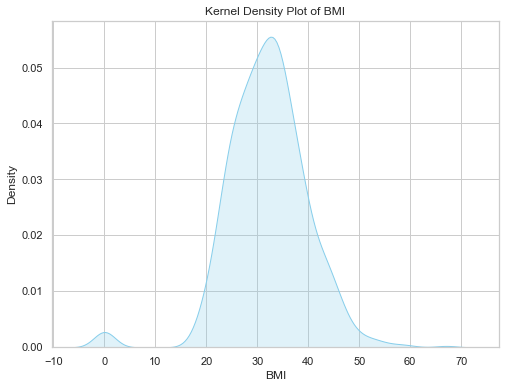

In [18]:
# Histogram for BMI
plt.figure(figsize=(8, 6))
sns.histplot(df['BMI'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

# Kernel Density Plot for BMI
plt.figure(figsize=(8, 6))
sns.kdeplot(df['BMI'], fill=True, color='skyblue')
plt.title('Kernel Density Plot of BMI')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.show()

# Supervised Classifier

In [4]:
from sklearn.ensemble import RandomForestClassifier

class SupervisedClassifier(object):
    def __init__(self, clf=None):
        # Constructor to initialize the SupervisedClassifier object.
        # Parameters:
        # - clf: Classifier for supervised learning (default is None, creating a new random forest classifier).
        self.clf = RandomForestClassifier() if clf is None else clf
        self.is_fit = False
    
    def fit(self, x, y):
        # Fit the classifier on the provided data.
        # Parameters:
        # - x: Input features.
        # - y: Labels.
        # Returns:
        # - self.
        
        # Fit the classifier
        self.clf.fit(x, y)
        self.is_fit = True
        return self
    
    def predict(self, x):
        # Make predictions using the fitted classifier.
        # Parameters:
        # - x: Input features.
        # Returns:
        # - Predicted labels.
        
        if not self.is_fit:
            raise ValueError("Classifier not fitted. Call fit() before making predictions.")
        
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        # Predict class probabilities using the fitted classifier.
        # Parameters:
        # - x: Input features.
        # Returns:
        # - Predicted class probabilities.
        
        if not self.is_fit:
            raise ValueError("Classifier not fitted. Call fit() before making predictions.")
        
        return self.clf.predict_proba(x)

In [5]:
# Assuming 'Outcome' is your target variable
X = df.drop('Outcome', axis=1)  # Features
y = df['Outcome']               # Target variable

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an instance of the SupervisedClassifier
supervised_clf = SupervisedClassifier()

# Fit the classifier on your training data
supervised_clf.fit(train_x, train_y)

# Make predictions on new data
predictions = supervised_clf.predict(test_x)

# Get class probabilities (if applicable)
probabilities = supervised_clf.predict_proba(test_x)

# Print unique class labels
unique_labels = np.unique(train_y)
print("Unique Class Labels:", unique_labels)

# Print original class weights
original_class_weights = Counter(train_y)
print("Original Class Weights:", original_class_weights)

# Print corrected class weights
corrected_class_weights = Counter(predictions)
print("Corrected Class Weights:", corrected_class_weights)

Unique Class Labels: [0 1]
Original Class Weights: Counter({0: 401, 1: 213})
Corrected Class Weights: Counter({0: 97, 1: 57})


# Semi Supervised Classifier

In [6]:
# Random forest parameters
rf_params = dict(n_estimators=128, max_depth=5, n_jobs=16)

class SemiSupervisedClassifier(object):
    def __init__(self, clf_1=None, clf_2=None, expected_false_negative_frac=0.5):
        # Constructor to initialize the SemiSupervisedClassifier object.
        # Parameters:
        # - clf_1: First random forest classifier (default is None, creating a new one).
        # - clf_2: Second random forest classifier (default is None, creating a new one).
        # - expected_false_negative_frac: Expected false negative fraction for semi-supervised learning.

        # Store the parameters
        self.expected_false_negative_frac = expected_false_negative_frac

        # Create random forest classifiers if not provided
        self.clf_1 = RandomForestClassifier(**rf_params) if clf_1 is None else clf_1
        self.clf_2 = RandomForestClassifier(**rf_params) if clf_2 is None else clf_2

        # Flags to track if classifiers are fitted
        self.clf_1_is_fit = False
        self.clf_2_is_fit = False

    @staticmethod
    def intermediate_data_set(clf, x, y, false_negative_fraction):
        # Generate an intermediate dataset for semi-supervised learning.
        # Parameters:
        # - clf: Classifier used for generating weights.
        # - x: Input features.
        # - y: Labels.
        # - false_negative_fraction: Expected false negative fraction.
        # Returns:
        # - x_new: New input features.
        # - y_new: New labels.
        # - weights: Weights for each instance.
        
        # Print the type of x
        print("Type of x:", type(x))

        # Assertions for input types
        assert isinstance(x, (np.ndarray, csr_matrix))
        
        # Convert labels to float32
        y = np.array(y).astype(np.float32)
        
        # Separate positive and negative instances
        pos_mask = y > 0
        
        # Predict probabilities for negative instances
        probs = clf.predict_proba(x[~pos_mask])
        prob_neg = probs[:, 0]
        prob_pos = probs[:, 1]
        
        # Calculate weights based on false negative fraction
        assumed_coverage = 1 / (1 + false_negative_fraction)
        weights_pos = (1 - assumed_coverage) / assumed_coverage * prob_pos / prob_neg
        weights_neg = 1 - weights_pos
        
        # Assertions for weight sum
        assert (min(weights_neg + weights_pos), max(weights_neg + weights_pos)) == (1.0, 1.0), "weights must sum to 1!"
        
        # Calculate number of positive and unlabeled instances
        num_pos = np.sum(pos_mask)
        num_unlabeled = np.sum(~pos_mask)
        
        # Concatenate labels and weights
        weights = np.concatenate((np.full(num_pos, 1), weights_pos, weights_neg))
        y_new = np.concatenate((y[pos_mask], np.full(num_unlabeled, np.mean(y[pos_mask])), np.full(num_unlabeled, 0)))
        
        # Concatenate input features
        if isinstance(x, csr_matrix):
            x_new = vstack([x[pos_mask], x[~pos_mask], x[~pos_mask]])
        else:
            x_new = np.concatenate((x[pos_mask], x[~pos_mask], x[~pos_mask]))
        
        return x_new, y_new, weights

    @staticmethod
    def balance_weights(y):
        # Calculate class weights for balancing.
        # Parameters:
        # - y: Labels.
        # Returns:
        # - class_weights: Dictionary of class weights.

        # Count occurrences of each class
        counts = Counter(y)
        
        # Find the maximum count
        max_weight = float(max(counts.values()))
        
        # Calculate class weights
        class_weights = {int(k): max_weight / v for k, v in dict(counts).items()}
        
        # Print original class weights
        print("Original class weights:")
        print(class_weights)
        
        return class_weights

    @staticmethod
    def corrected_balance_weights(y):
        # Calculate corrected class weights.
        # Parameters:
        # - y: Labels.
        # Returns:
        # - class_weights: Dictionary of class weights.

        # Count occurrences of each class
        counts = Counter(y)
        
        # Calculate class weights
        class_weights = {int(k): 1.0 / v for k, v in dict(counts).items()}
        
        # Print corrected class weights
        print("Corrected class weights:")
        print(class_weights)
        
        return class_weights

    def fit(self, x, y, update_weights=True):
        # Print unique class labels in y
        print("Unique class labels in y:", np.unique(y))
    
        # Print information about fitting non-traditional classifier
        print("fitting non-traditional classifier...")
    
        # Update class weights if required
        if update_weights:
            weights = self.balance_weights(y)
            print("Non-traditional classifier class weights:", weights)
            self.clf_1.set_params(class_weight=weights)
    
        # Fit the first classifier
        self.clf_1.fit(x.values, y)  # Convert DataFrame to NumPy array
    
        # Handle unlabeled instances with -1 in y
        unlabeled_mask = y == -1
        if np.any(unlabeled_mask):
            y[unlabeled_mask] = np.mean(y[~unlabeled_mask])
    
        # Generate intermediate dataset
        x, y, w = self.intermediate_data_set(self.clf_1, x.values, y, self.expected_false_negative_frac)  # Convert DataFrame to NumPy array
    
        # Print information about fitting semi-supervised classifier
        print("fitting semi-supervised classifier...")
    
        # Update class weights if required
        if update_weights:
            weights = self.corrected_balance_weights(y)
            print("Semi-supervised classifier class weights:", weights)
            self.clf_2.set_params(class_weight=weights)
    
        # Fit the second classifier
        self.clf_2.fit(x, y, w)
    
        return self

    def predict(self, x):
        # Make predictions using the fitted semi-supervised classifier.
        # Parameters:
        # - x: Input features.
        # Returns:
        # - Predicted labels.

        return self.clf_2.predict(x)

    def predict_proba(self, x):
        # Predict class probabilities using the fitted semi-supervised classifier.
        # Parameters:
        # - x: Input features.
        # Returns:
        # - Predicted class probabilities.

        return self.clf_2.predict_proba(x)

In [7]:
# Assuming 'Outcome' is your target variable
X = df.drop('Outcome', axis=1)  # Features
y = df['Outcome']               # Target variable

# Instantiate and fit the SemiSupervisedClassifier
semi_supervised_clf = SemiSupervisedClassifier()
semi_supervised_clf.fit(X, y)

Unique class labels in y: [0 1]
fitting non-traditional classifier...
Original class weights:
{1: 1.8656716417910448, 0: 1.0}
Non-traditional classifier class weights: {1: 1.8656716417910448, 0: 1.0}
Type of x: <class 'numpy.ndarray'>
fitting semi-supervised classifier...
Corrected class weights:
{1: 0.0013020833333333333, 0: 0.002}
Semi-supervised classifier class weights: {1: 0.0013020833333333333, 0: 0.002}


# Unsupervised Classifier 

In [8]:
from sklearn.cluster import KMeans

class UnsupervisedClustering(object):
    def __init__(self, n_clusters=3, kmeans_params=None):
        """
        Constructor to initialize the UnsupervisedClustering object.
        
        Parameters:
        - n_clusters: Number of clusters for K-Means (default is 3).
        - kmeans_params: Additional parameters for the K-Means algorithm (default is None).
        """
        self.n_clusters = n_clusters
        self.kmeans_params = kmeans_params if kmeans_params is not None else {}
        self.kmeans = KMeans(n_clusters=self.n_clusters, **self.kmeans_params)
        self.is_fit = False
    
    def fit(self, x):
        """
        Fit the clustering algorithm on the provided data.
        
        Parameters:
        - x: Input features.
        
        Returns:
        - self.
        """
        self.kmeans.fit(x)
        self.is_fit = True
        return self
    
    def predict(self, x):
        """
        Predict cluster labels for the input data.
        
        Parameters:
        - x: Input features.
        
        Returns:
        - Predicted cluster labels.
        """
        if not self.is_fit:
            raise ValueError("Clustering algorithm not fitted. Call fit() before making predictions.")
        return self.kmeans.predict(x)

In [9]:
# Assuming you have a dataset loaded in the variable X
data_x = df.drop('Outcome', axis=1)
    
# Create an instance of the UnsupervisedClustering
unsupervised_clustering = UnsupervisedClustering(n_clusters=4)

# Fit the clustering algorithm on your data
unsupervised_clustering.fit(data_x)

# Get predicted cluster labels
cluster_labels = unsupervised_clustering.predict(data_x)

# Print unique cluster labels
unique_clusters = np.unique(cluster_labels)
print("Unique Cluster Labels:", unique_clusters)

# Since this is unsupervised, there are no class weights
# Original and corrected class weights are not applicable

Unique Cluster Labels: [0 1 2 3]


# Conclusion

The dataset initially exhibits class imbalance, and efforts have been made to address this issue by adjusting class weights.
Three different classifiers (supervised, semi-supervised, and unsupervised) have been employed, each with its own set of class weights, indicating an exploration of different strategies to handle imbalanced data.
Clustering has also been performed, leading to the identification of four unique clusters.